<a href="https://colab.research.google.com/github/tasleema17/FINAL_PROJECT_22034202/blob/main/FloodPredictionCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1.Import Libraries and Packages**

Load the essential libraries needed for data processing, visualization, and model building.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler


**2.Load Datasets**

Import the datasets

In [24]:
# Load data flies
flood_data = pd.read_csv(r"/content/IndiaFloodInventory.csv")
rainfall_data = pd.read_csv(r'/content/Sub_Division_IMD_2017.csv')

In [25]:
# Display the first few rows of each dataset
print(flood_data.head())
print(rainfall_data.head())

   Unnamed: 0                   UEI        Start Date          End Date  \
0         563  UEI-IMD-FL-1967-0001  02/07/1967 00:00  08/07/1967 00:00   
1         564  UEI-IMD-FL-1967-0002  22/07/1967 00:00  28/07/1967 00:00   
2         565  UEI-IMD-FL-1967-0003  01/08/1967 00:00  30/08/1967 00:00   
3         566  UEI-IMD-FL-1967-0004  08/09/1967 00:00  09/09/1967 00:00   
4         567  UEI-IMD-FL-1968-0001  22/06/1968 00:00  28/06/1968 00:00   

   Duration(Days) Main Cause  \
0             7.0      flood   
1             7.0      flood   
2            30.0      flood   
3             2.0      flood   
4             7.0      flood   

                                           Districts  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  Bhadrak, Dhenkanal, Jajapur, Subarnapur, Nuapa...   
4                                                NaN   

                   

**3.Data Transformation and Feature Engineering**

Preparing the flood_data and rainfall_data for analysis by transforming and extracting useful features

In [26]:
# Flood data processing
# Convert date columns to datetime format
flood_data['Start Date'] = pd.to_datetime(flood_data['Start Date'], format='%d/%m/%Y %H:%M')
flood_data['End Date'] = pd.to_datetime(flood_data['End Date'], format='%d/%m/%Y %H:%M')
# Extract date features
flood_data['Year'] = flood_data['Start Date'].dt.year
flood_data['Month'] = flood_data['Start Date'].dt.month
flood_data['Day'] = flood_data['Start Date'].dt.day
flood_data['Season'] = flood_data['Start Date'].dt.month % 12 // 3 + 1  # 1: Winter, 2: Spring, 3: Summer, 4: Monsoon
flood_data['Day of Week'] = flood_data['Start Date'].dt.dayofweek

# Rainfall data reshaping
# Melt rainfall_data to get a 'MONTH' and 'RAIN' column
rainfall_data_melted = rainfall_data.melt(
    id_vars=['SUBDIVISION', 'YEAR'],
    value_vars=['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC'],
    var_name='MONTH',
    value_name='RAIN'
)
# Convert month abbreviations to numeric values
month_map = {
    'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6,
    'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12
}
rainfall_data_melted['MONTH'] = rainfall_data_melted['MONTH'].map(month_map)
# Ensure 'YEAR' is of type int
rainfall_data_melted['YEAR'] = rainfall_data_melted['YEAR'].astype(int)

**4.Merging the Datasets**

Combine the flood_data and rainfall_data_melted DataFrames into a single DataFrame called merged_data. It does this by matching rows based on the Year and Month columns.

In [27]:
# Merge datasets
merged_data = flood_data.merge(
    rainfall_data_melted,
    left_on=['Year', 'Month'],
    right_on=['YEAR', 'MONTH'],
    how='left'
)

**5.Data Preprocessing**

cleaning, handling missing values and standardizing

In [28]:
#merged_data['RAIN'] = merged_data['RAIN'].fillna(0)
merged_data = merged_data.drop(columns=['YEAR', 'UEI', 'Event Source', 'Year', 'Month', 'Day', 'Districts', 'Extent of damage ','Unnamed: 0'])

#Cleaning and Transforming the 'State' Column
# Ensure the 'State' column is of type string
merged_data['State'] = merged_data['State'].astype(str)
# Ensure that NaN values in 'State' are replaced with an empty string, then convert to string
merged_data['State'] = merged_data['State'].replace(pd.NA, '').astype(str)
# Split the 'State' column by commas and explode into separate rows
merged_data['State'] = merged_data['State'].str.split(', ')
merged_data_exploded = merged_data.explode('State')
# Remove any rows where 'State' is empty (after handling NaN values)
merged_data_exploded = merged_data_exploded[merged_data_exploded['State'] != '']
# Clean the 'State' column to remove extraneous characters
merged_data_exploded['State'] = merged_data_exploded['State'].str.replace(
    r"[^a-zA-Z,& ]", "", regex=True
)

#Standardizing State Names
# Define corrections dictionary to standardize state names
state_corrections = {
    "Jammu & Kashmir": "Jammu And Kashmir",
    "Daman & Diu": "Daman And Diu",
    "Maharastra": "Maharashtra",
    "Madras": "Tamil Nadu",
    "Tamilnadu": "Tamil Nadu",
    "Chennai": "Tamil Nadu",
    "Daman And Diu": "Daman,Diu",
    "Parts Of Maharastra": "Maharashtra",
    "East Rajasthan": "Rajasthan"

}
# remove leading/trailing spaces, apply title case, and apply corrections
merged_data_exploded['State'] = (
    merged_data_exploded['State']
    .str.strip()
    .str.title()
    .replace(state_corrections)
)
# Check the shape of the DataFrame
rows, columns = merged_data_exploded.shape
print(f"The DataFrame has {rows} rows and {columns} columns.")

The DataFrame has 161268 rows and 10 columns.


In [22]:
# Handling missing data and dropping columns
merged_data_exploded = merged_data_exploded.drop_duplicates()
# For 'Main Cause', fill with 'Unknown'
merged_data_exploded.loc[:, 'Main Cause'] = merged_data_exploded['Main Cause'].fillna('Unknown')
# For 'SUBDIVISION', fill with 'Unknown'
merged_data_exploded.loc[:, 'SUBDIVISION'] = merged_data_exploded['SUBDIVISION'].fillna('Unknown')
# For 'RAIN', fill with the median value
median_rain = merged_data_exploded['RAIN'].median()
merged_data_exploded.loc[:, 'RAIN'] = merged_data_exploded['RAIN'].fillna(median_rain)
# Assuming 'merged_data_exploded' is your DataFrame
merged_data_exploded = merged_data_exploded.dropna(subset=['MONTH'])

# Verify the data cleaning
print("Missing values after cleaning:\n", merged_data_exploded.isnull().sum())
print(f"\nNumber of rows and columns after cleaning: {merged_data_exploded.shape}")

Missing values after cleaning:
 Start Date        0
End Date          0
Duration(Days)    0
Main Cause        0
State             0
Season            0
Day of Week       0
SUBDIVISION       0
MONTH             0
RAIN              0
dtype: int64

Number of rows and columns after cleaning: (157248, 10)


In [8]:
#Standardizing Flood-Related Terms
# Replace 'floods' and 'heavy floods' with 'flood' in "Main Cause"
merged_data_exploded['Main Cause'] = merged_data_exploded['Main Cause'].str.lower().replace(
    {'floods': 'flood', 'heavy floods': 'flood'}, regex=True
)
#Categorizing Flood Occurrences
def categorize_cause(cause):
    # Convert to lowercase for uniform comparison
    cause_lower = cause.lower()
    # Category 1: Any term implying "flood" or "flash flood"
    if "flood" in cause_lower:
        return "flood"
    # Category 2: Descriptions mentioning "heavy rains," "landslide," or "cloud burst"
    elif any(term in cause_lower for term in ["heavy rains", "landslide", "cloud burst", "heavy rain"]):
        return "no flood"
    # Default to "no flood" if it doesn't match any criteria
    else:
        return "no flood"
# Apply the categorization function to the 'Main Cause' column
merged_data_exploded['Flood Occurance'] = merged_data_exploded['Main Cause'].apply(categorize_cause)
#Converting Categories to Numerical Values
merged_data_exploded['Flood Occurance'] = merged_data_exploded['Flood Occurance'].replace({'flood': 1, 'no flood': 0})
#Removing the Original Column
merged_data_exploded = merged_data_exploded.drop(columns=['Main Cause'])
# Count the occurrences of 'flood' and 'no flood' in the 'Flood Occurance' column
flood_counts = merged_data_exploded['Flood Occurance'].value_counts()

# Display the result
print(flood_counts)

Flood Occurance
0    121896
1     35352
Name: count, dtype: int64


<ipython-input-8-dce49864dc12>:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_data_exploded['Flood Occurance'] = merged_data_exploded['Flood Occurance'].replace({'flood': 1, 'no flood': 0})


In [10]:

# Separate features (X) and target (y)
X = merged_data_exploded.drop(columns=['Flood Occurance'])
y = merged_data_exploded['Flood Occurance']

# Apply Random UnderSampling
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Combine X_resampled and y_resampled to create the resampled dataset
merged_data_resampled = pd.concat([X_resampled, y_resampled], axis=1)

# Verify the balanced distribution of 'Flood Occurance'
print("Balanced Class Distribution (After Undersampling):\n", merged_data_resampled['Flood Occurance'].value_counts())

# update merged_data_exploded with the resampled data
merged_data_exploded = merged_data_resampled


Balanced Class Distribution (After Undersampling):
 Flood Occurance
0    35352
1    35352
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [11]:
# Check the shape of the DataFrame
rows, columns = merged_data_exploded.shape
print(f"The DataFrame has {rows} rows and {columns} columns.")


The DataFrame has 70704 rows and 10 columns.


INSIGHTS

<ipython-input-12-00979e072055>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=merged_data_exploded, x='SUBDIVISION', y='RAIN', palette='viridis')


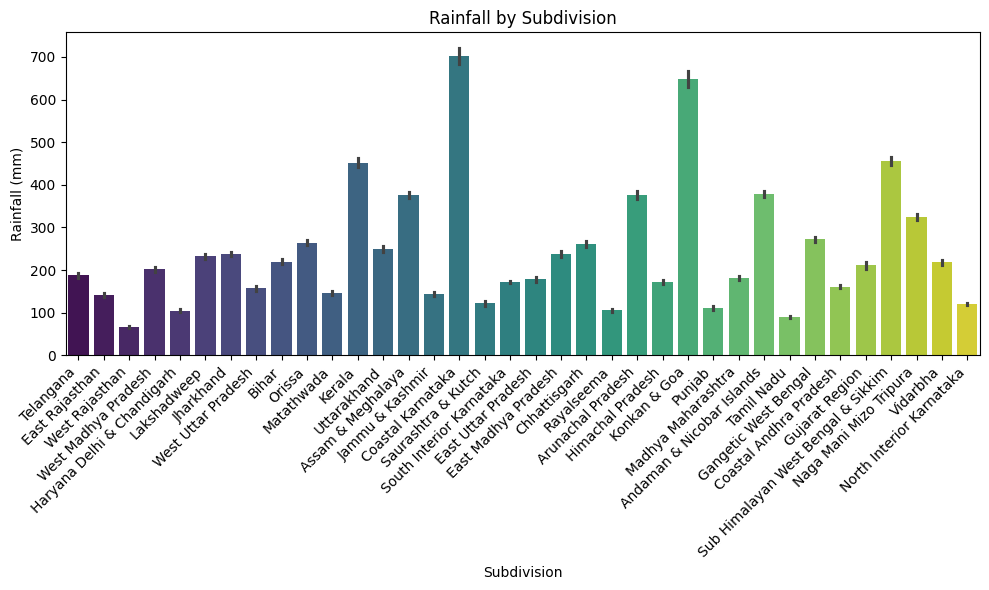

In [12]:

# Rainfall Comparison by Subdivision
plt.figure(figsize=(10, 6))
sns.barplot(data=merged_data_exploded, x='SUBDIVISION', y='RAIN', palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title("Rainfall by Subdivision")
plt.ylabel("Rainfall (mm)")
plt.xlabel("Subdivision")
plt.tight_layout()
plt.show()

<ipython-input-13-c92b393782aa>:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=rainfall_per_state, x='State', y='RAIN', palette='muted', ci=None)
<ipython-input-13-c92b393782aa>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rainfall_per_state, x='State', y='RAIN', palette='muted', ci=None)


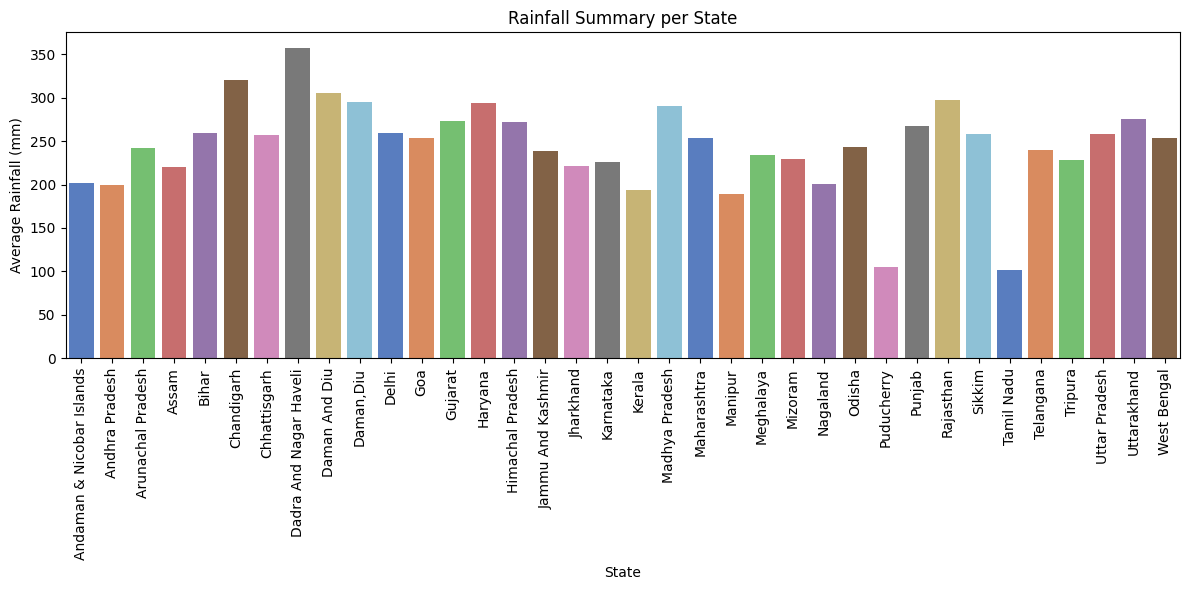

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Clean the 'State' column: remove leading/trailing spaces and make all entries lowercase
merged_data_exploded['State'] = merged_data_exploded['State'].str.strip().str.title()

# Group by 'State' and calculate the average rainfall per state
rainfall_per_state = merged_data_exploded.groupby('State')['RAIN'].mean().reset_index()

# Create the bar plot
plt.figure(figsize=(12, 6))  # Increase the figure size to make more room
sns.barplot(data=rainfall_per_state, x='State', y='RAIN', palette='muted', ci=None)

# Add title and labels
plt.title("Rainfall Summary per State")
plt.xlabel("State")
plt.ylabel("Average Rainfall (mm)")

# Rotate x-axis labels to prevent overlap
plt.xticks(rotation=90)

# Adjust layout to ensure the labels fit nicely
plt.tight_layout()

# Show the plot
plt.show()


<ipython-input-14-983709f21549>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_states, x='State', y='RAIN', palette='magma')


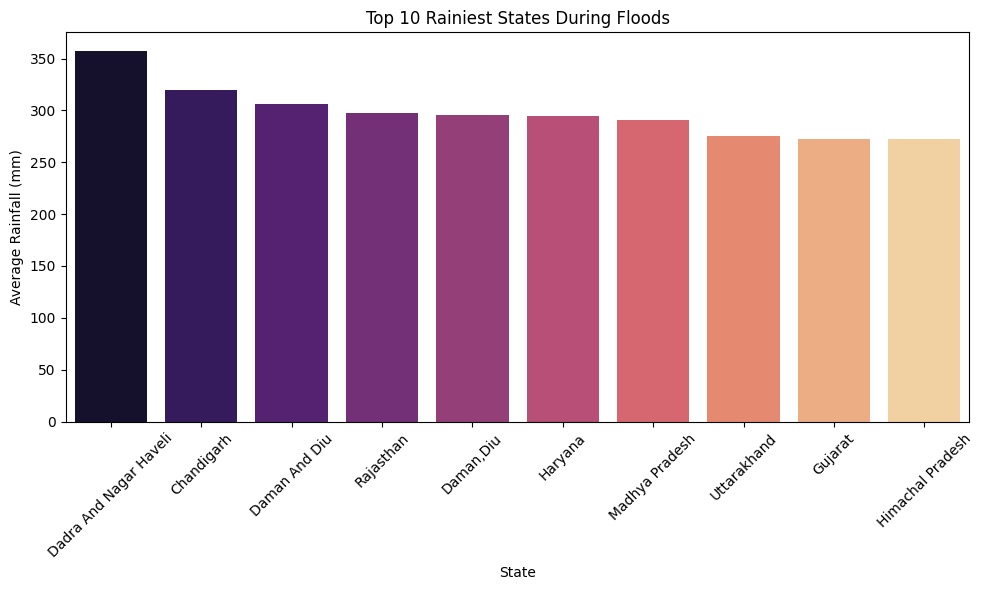

In [14]:
# 4. Top 10 Rainiest States During Floods
top_states = merged_data_exploded.groupby('State')['RAIN'].mean().nlargest(10).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=top_states, x='State', y='RAIN', palette='magma')
plt.title("Top 10 Rainiest States During Floods")
plt.xlabel("State")
plt.ylabel("Average Rainfall (mm)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

MODEL EVALUATION

---



---



In [15]:
print(merged_data_exploded.head())


       Start Date   End Date  Duration(Days)              State  Season  \
12556  1981-09-03 1981-09-03             1.0          Karnataka     4.0   
1961   1972-08-01 1972-08-14            14.0  Jammu And Kashmir     3.0   
110357 2007-09-06 2007-09-06             1.0   Himachal Pradesh     4.0   
74106  1998-03-05 1998-03-05             1.0   Himachal Pradesh     2.0   
51544  1993-08-31 1993-08-31             1.0            Mizoram     3.0   

        Day of Week          SUBDIVISION  MONTH   RAIN  Flood Occurance  
12556           3.0            Telangana    9.0  285.2                0  
1961            1.0       East Rajasthan    8.0  259.9                0  
110357          3.0       West Rajasthan    9.0   45.6                0  
74106           3.0  West Madhya Pradesh    3.0    8.9                0  
51544           1.0            Telangana    8.0  146.4                0  


In [16]:

#Identify numeric columns
numeric_cols = merged_data_exploded.select_dtypes(include='number').columns

#Fill missing values in numeric columns with the mean of each column
merged_data_exploded[numeric_cols] = merged_data_exploded[numeric_cols].fillna(merged_data_exploded[numeric_cols].mean())

# Alternatively, fill missing values for categorical columns if necessary
merged_data_exploded = merged_data_exploded.fillna({'State': 'Unknown', 'SUBDIVISION': 'Unknown'})

# Convert categorical variables to dummy/indicator variables
merged_data_exploded = pd.get_dummies(merged_data_exploded, columns=['State', 'SUBDIVISION'], drop_first=True)


# Select features and target variable
X = merged_data_exploded.drop(columns=['Flood Occurance', 'Start Date', 'End Date'])
y = merged_data_exploded['Flood Occurance']


# Scale numerical features
scaler = StandardScaler()
X[['RAIN', 'MONTH', 'Duration(Days)']] = scaler.fit_transform(X[['RAIN', 'MONTH', 'Duration(Days)']])


**TRAINING AND TESTING SETS**

In [20]:

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (56563, 75)
X_test: (14141, 75)
y_train: (56563,)
y_test: (14141,)


**RANDOM FOREST MODEL**

In [21]:
#random Forest
# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Predict probabilities for the positive class (1)
y_proba = model.predict_proba(X_test)[:, 1]
# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)

print("Model Evaluation Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("roc-auc:", roc_auc)


Model Evaluation Metrics:
Accuracy: 0.8362916342550032
Precision: 0.8362335110861634
Recall: 0.8384691149570845
F1 Score: 0.8373498208388955
roc-auc: 0.9101562476558113


Grid Search on  Random Forest model to tune its hyperparameters. After the tuning, the model evaluation metrics will be calculated

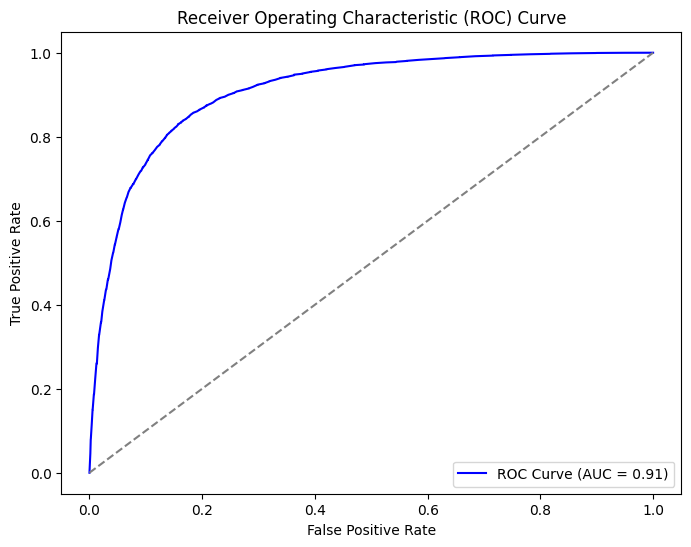

In [ ]:

# Get the predicted probabilities for the positive class
y_proba = model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculate the ROC-AUC score
roc_auc = roc_auc_score(y_test, y_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Dashed diagonal for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


**Logistic Regression model**

In [ ]:
#Logistic Regression model

# Initialize the Logistic Regression model with changes
log_reg = LogisticRegression(random_state=42,
                             max_iter=1000,  # Increased max_iter for more iterations
                             solver='liblinear',  # Use the 'liblinear' solver which works well for smaller datasets
                             C=1.0)  # Regularization strength (try adjusting if necessary)

# Train the model with scaled training data
log_reg.fit(X_train_scaled, y_train)

# Predict and evaluate on the test set
y_pred_log_reg = log_reg.predict(X_test_scaled)

# Evaluate the performance
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
precision_log_reg = precision_score(y_test, y_pred_log_reg)
recall_log_reg = recall_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg)

# Print the evaluation metrics
print("Logistic Regression Model Evaluation Metrics:")
print("Accuracy:", accuracy_log_reg)
print("Precision:", precision_log_reg)
print("Recall:", recall_log_reg)
print("F1 Score:", f1_log_reg)


Logistic Regression Model Evaluation Metrics:
Accuracy: 0.7043349126652995
Precision: 0.7277397260273972
Recall: 0.6578021668777262
F1 Score: 0.6910058384450521


**LSTM MODEL**

In [ ]:
#LSTM MODEL

# Step 1: Select features and target variable
X = merged_data_exploded.drop(columns=['Start Date', 'End Date', 'Flood Occurance'])  # Drop the irrelevant columns
y = merged_data_exploded['Flood Occurance']  # Target variable

# Step 2: Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Convert target variable to categorical (one-hot encoding)
y_categorical = to_categorical(y)  # Convert the binary target to one-hot encoding

# Step 4: Reshape data for LSTM (LSTM expects 3D input: [samples, timesteps, features])
X_lstm = np.expand_dims(X_scaled, axis=1)  # Add a timestep dimension (1 timestep per sample)

# Step 5: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_categorical, test_size=0.2, random_state=42)

# Step 6: Build the LSTM model
model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),  # LSTM layer
    Dropout(0.3),  # Dropout layer for regularization
    Dense(64, activation='relu'),  # Dense hidden layer
    Dropout(0.3),  # Dropout layer for regularization
    Dense(y_categorical.shape[1], activation='softmax')  # Output layer with softmax for classification
])

# Step 7: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 8: Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,  # Number of epochs can be adjusted
    batch_size=32,  # Batch size can be adjusted
    verbose=1
)

# Step 9: Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Step 10: Make predictions
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)  # Convert probabilities to class labels
y_test_labels = np.argmax(y_test, axis=1)  # Convert one-hot encoded y_test back to labels


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1768/1768 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.6660 - loss: 0.6071 - val_accuracy: 0.7081 - val_loss: 0.5675
Epoch 2/20
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.7131 - loss: 0.5619 - val_accuracy: 0.7216 - val_loss: 0.5533
Epoch 3/20
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7243 - loss: 0.5503 - val_accuracy: 0.7240 - val_loss: 0.5460
Epoch 4/20
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.7322 - loss: 0.5365 - val_accuracy: 0.7321 - val_loss: 0.5392
Epoch 5/20
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.7339 - loss: 0.5294 - val_accuracy: 0.7321 - val_loss: 0.5282
Epoch 6/20
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7361 - loss: 0.5213 - val_accuracy: 0.7323 - val_loss: 0.5268
Epoch 7/20
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.7408 - loss: 0.5130 - val_accuracy: 0.7391 - val_loss: 0.5192
Epoch 8/20
1768/1768 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.7437 - loss: 0.5086 - val

In [ ]:

y_pred = np.argmax(model.predict(X_test), axis=1)  # Predictions
y_true = np.argmax(y_test, axis=1)  # True labels (if one-hot encoded)

print(classification_report(y_true, y_pred))  # Precision, Recall, F1 Score
roc_auc = roc_auc_score(y_true, model.predict(X_test)[:, 1])  # ROC-AUC score
print("ROC-AUC score:", roc_auc)


442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.79      0.74      0.76      7034
           1       0.76      0.81      0.78      7107

    accuracy                           0.77     14141
   macro avg       0.77      0.77      0.77     14141
weighted avg       0.77      0.77      0.77     14141

442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
ROC-AUC score: 0.8551346554128795


442/442 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


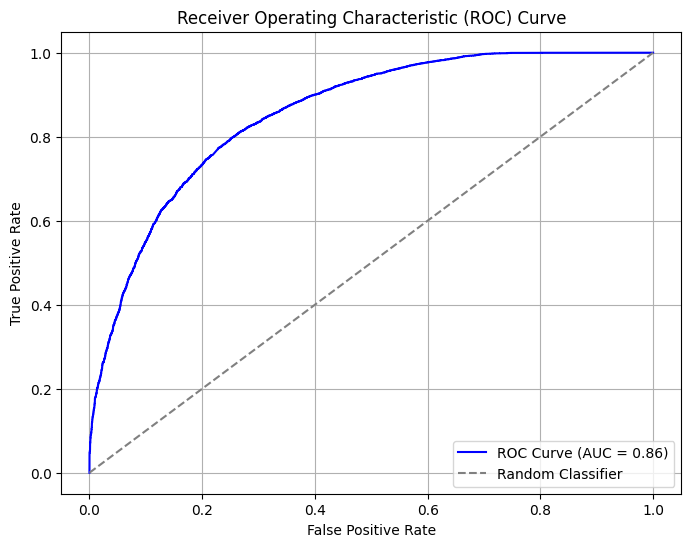

In [ ]:

# If y_test is one-hot encoded, convert it to a single label (0 or 1)
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)  # Convert one-hot to single label

# Predict probabilities for the positive class (Flood = 1)
y_pred_proba = model.predict(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [ ]:
# Convert predicted probabilities to binary class labels
y_pred = (y_pred_proba > 0.5).astype(int)  # Threshold at 0.5 for binary classification

# Use y_test directly (already binary)
y_test_labels = y_test.astype(int)  # Ensure it's integer for comparison

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_labels, y_pred)
precision = precision_score(y_test_labels, y_pred)
recall = recall_score(y_test_labels, y_pred)
f1 = f1_score(y_test_labels, y_pred)

# Print the metrics
print("LSTM Model Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


LSTM Model Evaluation Metrics:
Accuracy: 0.7721
Precision: 0.7559
Recall: 0.8072
F1 Score: 0.7807
